[INFO] Loading data from data/sydney_rain_prediction.csv
[INFO] Saved feature_columns.pkl
[INFO] Saved scaler.pkl
[INFO] Training lr
[INFO] Saved lr.pkl
[INFO] Training rf
[INFO] Saved rf.pkl
[INFO] Training xgb
C:\Users\garvs\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [19:37:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[INFO] Saved xgb.pkl
[INFO] Training lgbm


[LightGBM] [Info] Number of positive: 692, number of negative: 1977
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1900
[LightGBM] [Info] Number of data points in the train set: 2669, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.259273 -> initscore=-1.049750
[LightGBM] [Info] Start training from score -1.049750


[INFO] Saved lgbm.pkl
C:\Users\garvs\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [19:37:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\garvs\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [19:37:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\garvs\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [19:37:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\garvs\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [19:37:50] WARNING: C:\actions-runner\_work\xgboos

C:\Users\garvs\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [19:38:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[INFO] Saved best_xgb.pkl with params {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}
[INFO] Training stacking ensemble
[INFO] Saved stacking_ensemble.pkl
[INFO] Baseline XGB → Accuracy: 0.8114, F1: 0.5855, ROC-AUC: 0.8527
[INFO] Stacking → Accuracy: 0.8383, F1: 0.6301, ROC-AUC: 0.8614
[INFO] Saved ROC curve to outputs/plots\roc_curve.png


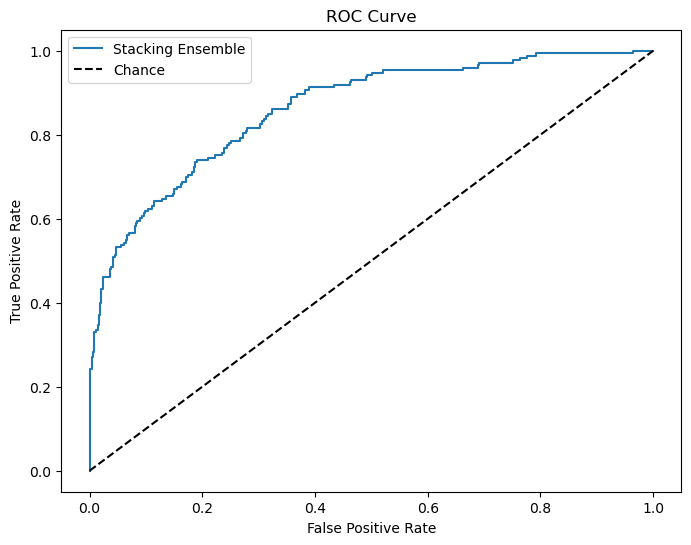

[INFO] Saved feature importances to outputs/plots\feature_importance.png


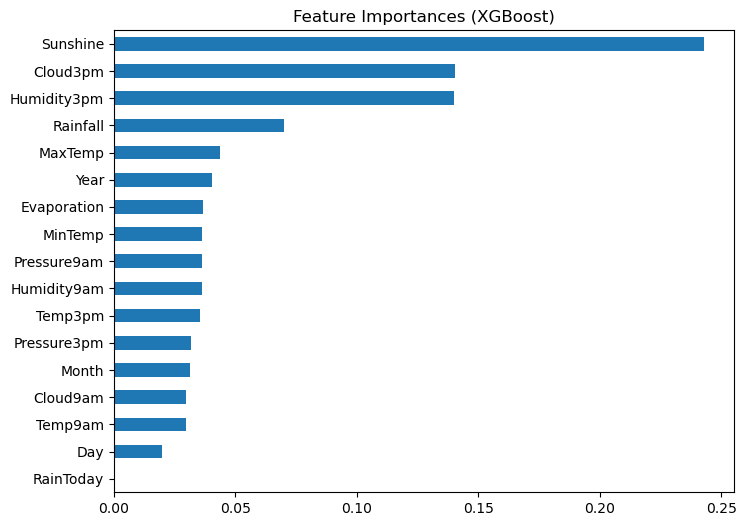

[INFO] Saved SHAP summary to outputs/plots\shap_summary.png


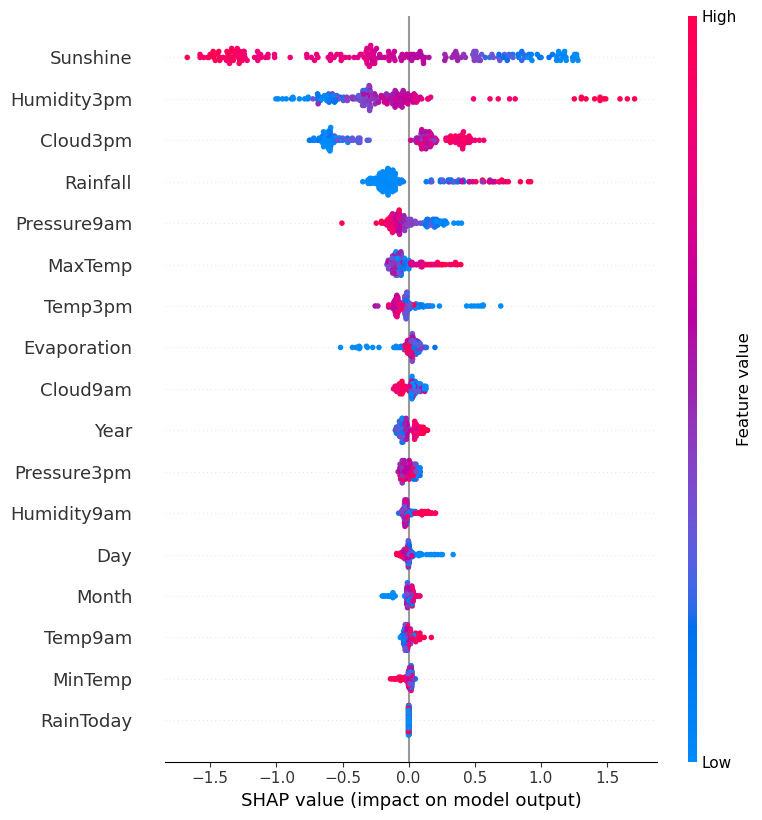

In [1]:
# train_model.py

import os
import logging
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')


def load_data(fp):
    logging.info(f"Loading data from {fp}")
    df = pd.read_csv(fp)
    df.dropna(how='all', inplace=True)
    df = df[df['RainTomorrow'].notna()]
    return df


def preprocess_data(df):
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df[df['Date'].notna()]
    df['Year'], df['Month'], df['Day'] = df['Date'].dt.year, df['Date'].dt.month, df['Date'].dt.day
    df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})
    df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})
    df.drop(['Date', 'Location'], axis=1, inplace=True, errors='ignore')

    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = KNNImputer(n_neighbors=5).fit_transform(df[num_cols])

    if 'WindGustSpeed' in df.columns and 'WindSpeed9am' in df.columns:
        df['WindDiff'] = df['WindGustSpeed'] - df['WindSpeed9am']

    for col in ['Rainfall', 'Evaporation', 'Sunshine']:
        if col in df:
            up = df[col].quantile(0.99)
            df[col] = np.clip(df[col], df[col].min(), up)

    return df


def split_and_scale(df):
    X = df.drop('RainTomorrow', axis=1)
    y = df['RainTomorrow']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    os.makedirs("outputs/models", exist_ok=True)
    joblib.dump(X_train.columns.tolist(), "outputs/models/feature_columns.pkl")
    logging.info("Saved feature_columns.pkl")

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    joblib.dump(scaler, "outputs/models/scaler.pkl")
    logging.info("Saved scaler.pkl")

    return X_train, X_test, X_train_s, X_test_s, y_train, y_test


def train_base_models(X_train_s, y_train):
    models = {
        "lr": LogisticRegression(max_iter=1000),
        "rf": RandomForestClassifier(random_state=42),
        "xgb": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "lgbm": LGBMClassifier(random_state=42)
    }
    for name, m in models.items():
        logging.info(f"Training {name}")
        m.fit(X_train_s, y_train)
        joblib.dump(m, f"outputs/models/{name}.pkl")
        logging.info(f"Saved {name}.pkl")

    param = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.9, 1.0]
    }
    rs = RandomizedSearchCV(models['xgb'], param, n_iter=10, scoring='roc_auc', cv=3, random_state=42)
    rs.fit(X_train_s, y_train)
    best = rs.best_estimator_
    joblib.dump(best, "outputs/models/best_xgb.pkl")
    logging.info(f"Saved best_xgb.pkl with params {rs.best_params_}")
    return models, best


def build_stacking(models, best_xgb, X_train_s, y_train):
    estimators = [
        ('lr', models['lr']),
        ('rf', models['rf']),
        ('lgbm', models['lgbm']),
        ('xgb', best_xgb)
    ]
    stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1)
    logging.info("Training stacking ensemble")
    stack.fit(X_train_s, y_train)
    joblib.dump(stack, "outputs/models/stacking_ensemble.pkl")
    logging.info("Saved stacking_ensemble.pkl")
    return stack


def evaluate_and_plot(models, stack, best_xgb, X_train, X_test_s, y_test):
    # Prepare plots directory
    import shutil
    plots_dir = "outputs/plots"
    if os.path.exists(plots_dir):
        shutil.rmtree(plots_dir)
    os.makedirs(plots_dir, exist_ok=True)

    # Evaluate metrics
    def eval_metrics(name, model_obj):
        y_p = model_obj.predict(X_test_s)
        y_pr = model_obj.predict_proba(X_test_s)[:, 1]
        acc = accuracy_score(y_test, y_p)
        f1 = f1_score(y_test, y_p)
        auc = roc_auc_score(y_test, y_pr)
        logging.info(f"{name} → Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC-AUC: {auc:.4f}")
        return y_pr

    _ = eval_metrics("Baseline XGB", models['xgb'])
    stack_proba = eval_metrics("Stacking", stack)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, stack_proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label="Stacking Ensemble")
    plt.plot([0,1], [0,1], 'k--', label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    roc_path = os.path.join(plots_dir, "roc_curve.png")
    plt.savefig(roc_path, bbox_inches='tight')
    logging.info(f"Saved ROC curve to {roc_path}")
    plt.show()

    # Feature Importance (XGBoost)
    importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns).sort_values()
    plt.figure(figsize=(8,6))
    importances.plot.barh()
    plt.title("Feature Importances (XGBoost)")
    fi_path = os.path.join(plots_dir, "feature_importance.png")
    plt.savefig(fi_path, bbox_inches='tight')
    logging.info(f"Saved feature importances to {fi_path}")
    plt.show()

    # SHAP Summary Plot
    explainer = shap.TreeExplainer(best_xgb)
    shap_vals = explainer.shap_values(X_test_s[:200])
    plt.figure(figsize=(8,6))
    shap.summary_plot(shap_vals, pd.DataFrame(X_test_s[:200], columns=X_train.columns), show=False)
    shap_path = os.path.join(plots_dir, "shap_summary.png")
    plt.savefig(shap_path, bbox_inches='tight')
    logging.info(f"Saved SHAP summary to {shap_path}")
    plt.show()


def main():
    df = load_data("data/sydney_rain_prediction.csv")
    df = preprocess_data(df)
    X_train, X_test, X_train_s, X_test_s, y_train, y_test = split_and_scale(df)
    models, best_xgb = train_base_models(X_train_s, y_train)
    stack = build_stacking(models, best_xgb, X_train_s, y_train)
    evaluate_and_plot(models, stack, best_xgb, X_train, X_test_s, y_test)


if __name__ == "__main__":
    main()
